Recreation of https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import save
from torch import load
from os import path

#import torch.utils.tensorboard as tb

from PIL import Image

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random 
import os, math

import gc

import pdb
from skimage import io 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

Reproducibility

In [ ]:
# Set manual seed.
def runRamdomSeed():
    torch.manual_seed(234)
    np.random.seed(234)
    random.seed(234)
    # Disabling the benchmarking feature with torch.backends.cudnn.benchmark = False 
    # causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance.
    torch.backends.cudnn.benchmark = False 

runRamdomSeed()

First we need to import our data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Then we need to establish how we will transform the data to fit into NN

In [ ]:
unused_data_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [ ]:

class OurDataset(Dataset):
    def __init__(self, csv_path, image_path, data_transforms=None):
        self.data_transforms = data_transforms
        self.image_path = image_path
        
        full_csv_frame = pd.read_csv(csv_path)
        csv_frame = full_csv_frame[["img_id", "city_id", "heading"]]
        
        self.pd_frame = csv_frame

        np_frame = csv_frame.to_numpy()

        

    def __len__(self):
        return self.pd_frame.iloc[:, 0].size


    def __getitem__(self, idx):
        image_path = self.image_path + "/" + str(self.pd_frame.iloc[idx, 0]).zfill(5) 
        img1 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2]) ).zfill(3) + ".jpg")
        img2 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2] + 120)%360 ).zfill(3) + ".jpg")
        img3 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2] + 240)%360 ).zfill(3) + ".jpg")

        
        if self.data_transforms != None:
          img1 = self.data_transforms(img1)
          img2 = self.data_transforms(img2)
          img3 = self.data_transforms(img3)
        else:
          # Change from 640, 640, 3 to 3, 640, 640
          img1 = torch.from_numpy(np.asarray(img1))     # convert to PyTorch Tensor
          img2 = torch.from_numpy(np.asarray(img2))  
          img3 = torch.from_numpy(np.asarray(img3)) 
          img1 = np.asarray(img1).transpose(-1, 0, 1)
          img2 = np.asarray(img2).transpose(-1, 0, 1)
          img3 = np.asarray(img3).transpose(-1, 0, 1)
        
        # img1 = torch.from_numpy(np.asarray(img1))     # convert to PyTorch Tensor (covered in transforms?)
        # img2 = torch.from_numpy(np.asarray(img2))     
        # img3 = torch.from_numpy(np.asarray(img3))     


        return (img1, img2, img3) , self.pd_frame.iloc[idx, 1]


Start by grabbing the already existing ResNet18 library

In [ ]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features


# resize last layer to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)


model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Helper functions to save and validate

In [ ]:
def save_model(model, name):
  save(model.state_dict(), name + ".pth")


In [ ]:
# Test on Val set
def accuracy_labels(preds, labels):
    return np.sum(preds == labels)/len(preds)

def get_ypred(X, val_model):
  X0 = X[0].to(device)
  X0 = X0.float()
  out0 = val_model(X0)

  X1 = X[1].to(device)
  X1 = X1.float()
  out1 = val_model(X1)

  X2 = X[2].to(device)
  X2 = X2.float()
  out2 = val_model(X2)

  out = out0+out1+out2
  y_pred = torch.argmax(out, dim = 1).tolist()
  return map(int, y_pred)


def get_val_accuracy(val_model):
  out_preds = []
  out_labels = []
  for (X,Y) in validloader:
    Y = Y.to(device)
    y_pred = get_ypred(X, val_model)
    out_preds.extend(list(y_pred))
    out_labels.extend(Y.tolist())
      
  this_val_acc = accuracy_labels(np.array(out_preds), np.array(out_labels))
  return this_val_acc, out_preds, out_labels

In [ ]:
# Validate loaded model

val_model = model_ft
val_dict = load("/content/drive/Shareddrives/GeoTracking_AI/4_16_28epoch_acc828.pth")
val_model.load_state_dict(val_dict)

acc, out_preds, out_labels = get_val_accuracy(val_model)

print(acc)

0.8025


[Text(0, 0.5, 'City'),
 Text(0.5, 0, 'Percentage Correct'),
 Text(0.5, 1.0, 'Validation Accuracy by City')]

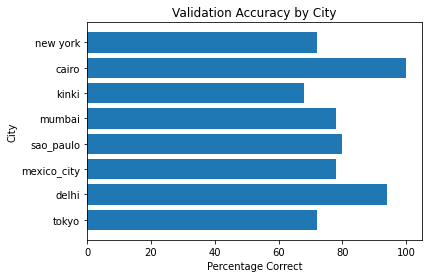

In [ ]:
total = np.zeros(8)
correct = np.zeros(8)
city_labels = ['tokyo', 'delhi', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york']

for i in range(0,len(out_labels)):
  index = out_labels[i]

  if index > 2 and index < 9:
    index = index - 1

  total[index] = total[index] + 1

  if out_labels[i] == out_preds[i]:
    correct[index] = correct[index] + 1

percentages = 100*correct/total

fig, ax = plt.subplots()

ax.barh(city_labels,percentages)
ax.set(xlabel = 'Percentage Correct', ylabel = 'City', title = 'Validation Accuracy by City')

[Text(0, 0.5, 'City'),
 Text(0.5, 0, 'Times Guessed'),
 Text(0.5, 1.0, 'Times Guessed by City')]

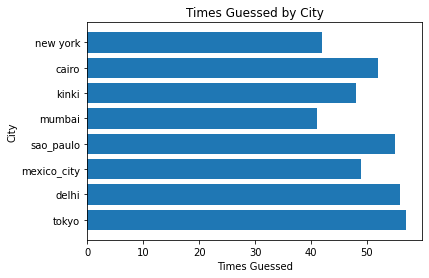

In [ ]:
count = np.zeros(8)
city_labels = ['tokyo', 'delhi', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york']

for i in range(0,len(out_labels)):
  index = out_preds[i]

  if index > 2 and index < 9:
    index = index - 1

  count[index] = count[index] + 1

fig, ax = plt.subplots()

ax.barh(city_labels,count)
ax.set(xlabel = 'Times Guessed', ylabel = 'City', title = 'Times Guessed by City')

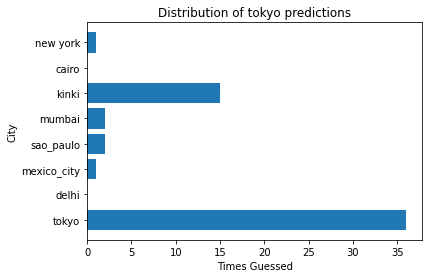

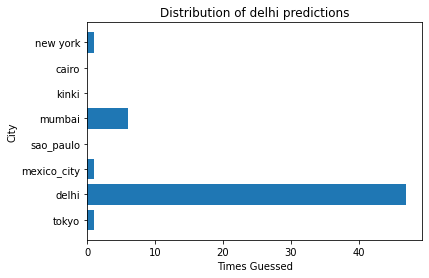

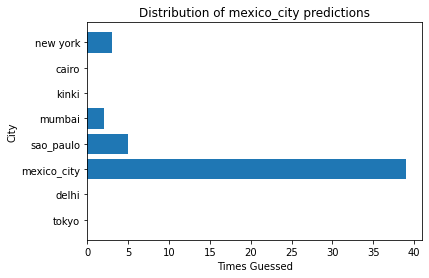

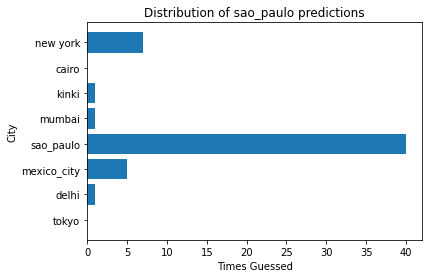

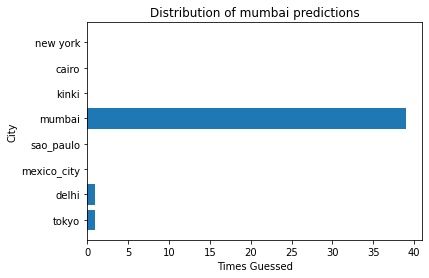

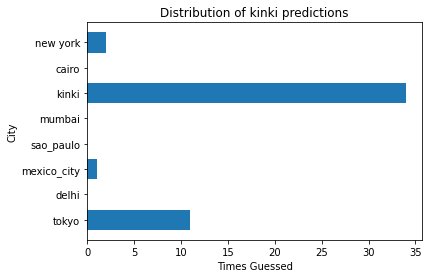

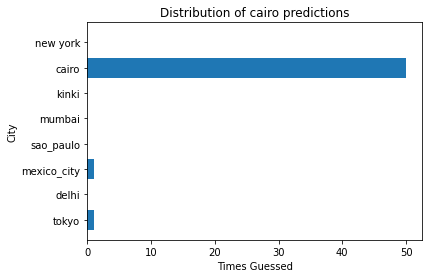

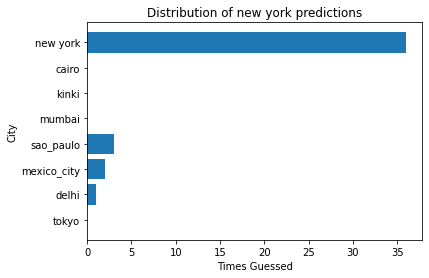

In [ ]:
city_labels = ['tokyo', 'delhi', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york']

for j in [0,1,3,4,5,6,7,8]:
  whats_tokyo = np.zeros(8)
  k = j
  if j > 2 and j < 9:
      k = j - 1

  for i in range(0,len(out_labels)):
    index = out_labels[i]

    if index > 2 and index < 9:
      index = index - 1

    if out_preds[i] == j:
      whats_tokyo[index] = whats_tokyo[index] + 1

  fig, ax = plt.subplots()

  ax.barh(city_labels,whats_tokyo)
  this_title = 'Distribution of ' + city_labels[k] + ' predictions'
  ax.set(xlabel = 'Times Guessed', ylabel = 'City', title = this_title)

Set Arguments

In [ ]:
class Args(object):
    pass

args = Args();

args.learning_rate = .001
args.max_epochs = 10
args.batch_size = 64
# args.batch_size = 1



In [ ]:
train_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_data.csv"
train_image_path = "/content/drive/Shareddrives/GeoTracking_AI/images"

workers = 2


transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = OurDataset(train_csv_path, train_image_path, data_transforms=transform)

trainloader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size = args.batch_size, 
                                          shuffle = True, 
                                          num_workers = workers)

valid_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_valid_data.csv"
valid_image_path = "/content/drive/Shareddrives/GeoTracking_AI/valid_images"

valid_dataset = OurDataset(valid_csv_path, valid_image_path, data_transforms=transform)
validloader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size = args.batch_size, 
                                          shuffle = True, 
                                          num_workers = workers)

Train new model

In [ ]:
def train_model(args, model):
  model_name = "/content/drive/Shareddrives/GeoTracking_AI/4_16_attempt2"
  print("Begin training model: ", model_name)
  if (path.exists(model_name + ".pth")): 
    print()
    print("Warning: You are about to overwrite a saved model !!!")
    print()
  print()
  

  model = model.to(device) 
  optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
  criterion = nn.CrossEntropyLoss()

  prev_val_acc = 0
  running_loss = 0.0
  best_val_acc = -1000

  for epoch in range(args.max_epochs):     # will get interupted by convergence test if validation acc drops
    for i, data in enumerate(trainloader, 0):
      print("finished data grab")
      outputs = []
      labels = 100
     

      for j in range(3):
        img = data[0][j]
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = img.to(device), data[1].to(device)
        inputs = inputs.float()                                    # Broke our RAM (?)
        outputs.append(model(inputs))
      
      
      combined_outputs = np.sum(outputs)/3
      loss = criterion(combined_outputs, labels)
      loss.backward()
      running_loss += loss.item()
    
      
      # handling batching manually to try and make things run faster
      man_batch_size = 1

      if (i % man_batch_size == 0):
        optimizer.step()
        optimizer.zero_grad()
        print("batch", i/man_batch_size, "finished")


      # if i % 1000 == 999:    # print every 1000 mini-batches

      if i % (50 * man_batch_size) == (50 * man_batch_size) - 1:
          print('[%d, %5d] training loss: %.3f' %(epoch, i, running_loss / 1000))
          val_acc = get_val_accuracy(model)
          print('[%d, %5d] val_accuracy : %.3f' %(epoch, i, val_acc))
          if (val_acc > prev_val_acc):
              save_model(model, model_name)
              print("model_saved") 
              prev_val_acc = val_acc
          print()
          running_loss = 0.0


  print('Finished Training')
  return model

In [ ]:
load_dict = load("/content/drive/Shareddrives/GeoTracking_AI/4_16_20epoch_acc79.pth")
model_ft.load_state_dict(load_dict)

model_ft = train_model(args, model_ft)

In [ ]:
# Validate loaded model

# val_model = model_ft
# val_dict = load("/content/drive/Shareddrives/GeoTracking_AI/4_15_attempt1.pth")
# val_model.load_state_dict(val_dict)
# print('new_val_acc: %.3f'  %( get_val_accuracy(val_model)))

Visualization of outputs:

In [ ]:
    example_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_example_data.csv"
    example_image_path = "/content/drive/Shareddrives/GeoTracking_AI/example_images"
    
    # dataset = OurDataset(example_csv_path, example_image_path, data_transforms=None)

In [ ]:
# Note: modified from homework 4 given code

LABEL_ = ['tokyo', 'delhi', 'shanghai', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york', 'bejing']

def visualize_data():
    example_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_example_data.csv"
    example_image_path = "/content/drive/Shareddrives/GeoTracking_AI/example_images"
    
    dataset = OurDataset(example_csv_path, example_image_path, data_transforms=None)
    loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size = 1, 
                                          shuffle = True, 
                                          num_workers = 2)

    f, axes = plt.subplots(3, len(LABEL_)-2,figsize=(25,5))

    counts = [0]*(len(LABEL_)-2)

    # for imgs, label in dataset:
    # for (i,data) in enumerate(loader,0):
    for (i,data) in enumerate(validloader,0):
        imgs = data[0]
        label = int(data[1].numpy())
        this_label = int(label)


        if label > 2 and label != 9:
          this_label = this_label-1
        if label != 2 and label != 9:

          X = imgs[0].to(device)
          X = X.float()         # Broke our RAM (working at 64, not 256)
          y_pred = torch.argmax(val_model(X), dim = 1).tolist()
          print(y_pred)
          y_pred_map = map(int, y_pred)

          

          c = counts[this_label]

          img = np.concatenate(imgs,axis=3)

          img = torch.from_numpy(img[0])

          if c < 3 :
              ax = axes[c][this_label]
              ax.imshow(img.permute(1, 2, 0).numpy())
              ax.axis('off')
              # ax.set_title(LABEL_[label])
              title = 'Acutal:' + str(LABEL_[label]) + ' \nGuessed:' + str(LABEL_[y_pred[0]])
              ax.set_title(title)
              counts[this_label] += 1
          
          if sum(counts) >= 3 * len(LABEL_):
              break

    plt.show()
    
visualize_data()

Report:

Complete:
* Made our own dataset
* Transfer Model w/ One Image (4/15)
* Transfer Model taking into account all 3 images - ensemble_training
* Have one very good model

* Model from Scratch (most simple)


* Visualization that we can see images, their correct labels, model's guess for label
* Percentage correct for each city bar graph



To Do:
* Get skip working
* More extensive human testing
  * 20 train, 50 test


        Write Report - 4/23-4/30


* Actually doing the write up
  * Skeleton the write up
      * ADAM?
      * Learning rate?
      * Choice of starting model for transfer model?
  * Divy up portions of the write up
  * Do the write up




  Note:  
  * Rubric ?? https://docs.google.com/document/d/11hMgJyKFbRhcXqQCRUTvuRtqn5mtXWEP6RpK97uTiNg/edit
  * Are we handing in code? Yes
